In [1]:
import pickle
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.ticker as mticker
import numpy as np
from ecdf import draw_cdf_line

with open("./attn_scores.pkl", "rb") as file:
    attn_probs = pickle.load(file)

In [2]:
def get_prob_matrix(attn_probs, layer, head):
    probs_layer = attn_probs[layer]
    probs = probs_layer[0, head, :, :]
    return probs

<Figure size 640x480 with 0 Axes>

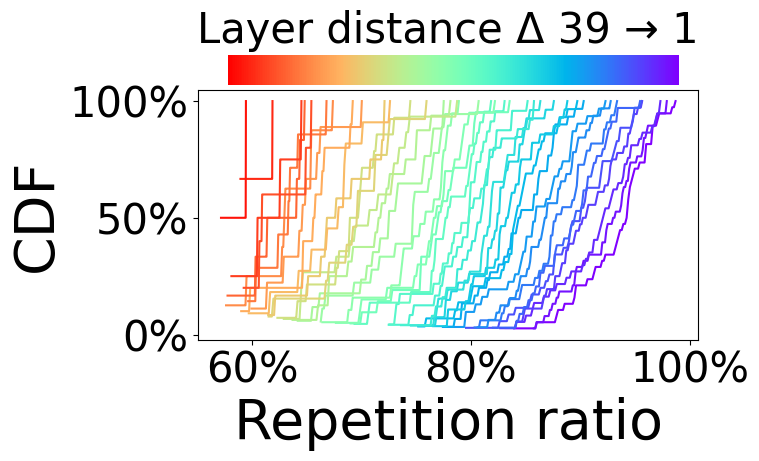

In [7]:
data_1 = [None for _ in range(48)]
# data_2 = [None for _ in range(24)]

high_token_percent = 0.45

for layer in range(24):
    all_probs_per_layer = []
    temp_sum = []
    for head in range(0, 4):
        p = get_prob_matrix(attn_probs, layer, head)
        temp_sum.append(torch.sum(p, dim=1, keepdim=True))
    sum_lst = torch.concat(temp_sum, dim=1)
    sum=torch.sum(sum_lst, dim=1)
    layer_data = [(i, v.item()) for i, v in enumerate(sum)]
    layer_data.sort(key=lambda x:x[1])
    layer_data = layer_data[int(2048*(1-high_token_percent)):]
    layer_data = set([x for x,_ in layer_data])
    data_1[layer*2] = layer_data
for layer in range(24):
    all_probs_per_layer = []
    temp_sum = []
    for head in range(4, 8):
        p = get_prob_matrix(attn_probs, layer, head)
        temp_sum.append(torch.sum(p, dim=1, keepdim=True))
    sum_lst = torch.concat(temp_sum, dim=1)
    sum=torch.sum(sum_lst, dim=1)
    layer_data = [(i, v.item()) for i, v in enumerate(sum)]
    layer_data.sort(key=lambda x:x[1])
    layer_data = layer_data[int(2048*(1-high_token_percent)):]
    layer_data = set([x for x,_ in layer_data])
    data_1[layer*2+1] = layer_data

delta_data = [[] for _ in range(39)]
for layer in range(2, 40):
    for another in range(layer+1, 42):
        delta = another - layer
        x: set = data_1[layer]
        y: set = data_1[another]
        z = x.difference(y)
        rep_ratio = 1 - len(z)/len(x)
        delta_data[delta-1].append(rep_ratio)

for idx in range(len(delta_data)):
    lst = delta_data[idx]
    for i in range(len(lst)):
        lst[i] -= 0.008*idx


plt.clf()
parameters = {"xtick.labelsize": 30, "ytick.labelsize": 30}
plt.rcParams.update(parameters)
plt.figure(figsize=(10, 5))
plt.subplots_adjust(left=0.4, bottom=0.25, top=0.75)
colors = iter(cm.rainbow(np.linspace(0, 1, 39)))
for data in delta_data:
    draw_cdf_line(plt, data, min(data), max(data), line_clr=next(colors))
    # draw_cdf_line(plt, layer2, min(layer2), max(layer2), line_clr=next(colors))
# for layer in all_scores:
#     draw_cdf_line(plt, layer, min(layer), max(layer), line_clr=next(colors))
plt.xlabel("Repetition ratio", fontsize=40)
# plt.xscale("symlog")
def format_ticks(x, pos):
     return f"{int(x*100)}%"
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(format_ticks)
plt.gca().xaxis.set_major_formatter(formatter)
def percent_ticks(x, pos):
     return f"{int(x*100)}%"
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_ticks))
# plt.xlim(-100, 100)
plt.ylabel("CDF", fontsize=40)
plt.text(0.55, 1.25, "Layer distance Δ 39 → 1", fontsize=30)

colorbar_ax = plt.axes([0.43, 0.76, 0.45, 0.06])

data = np.outer(np.ones(1000), np.arange(0, 1, 0.001))
colorbar_ax.imshow(data, aspect='auto', cmap='rainbow_r', origin='lower')
colorbar_ax.axis('off')

plt.savefig("cdf_token_repetition_ratio_import_opt_13b.pdf")
# plt.show()
